# v21.2 Inference Test - Korean Synonym Expansion (Legal/Medical)

This notebook tests the v21.2 Korean synonym expansion SPLADE model with legal and medical domain vocabulary.

## Expected Behavior

```
입력: "손해배상"
기대 출력: 손해배상(3.5), 배상(3.2), 보상(2.8), 책임(2.5), 손해(2.3)

입력: "진단"
기대 출력: 진단(3.5), 진찰(3.2), 검진(2.8), 소견(2.5)
```

The model should activate Korean synonyms including specialized legal and medical terminology.

In [1]:
import sys
from pathlib import Path

def find_project_root():
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists() or (parent / "src").exists():
            return parent
    return Path.cwd().parent.parent

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

import torch
import torch.nn as nn
import json
from transformers import AutoTokenizer, AutoModelForMaskedLM

print(f"Project root: {PROJECT_ROOT}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train
PyTorch version: 2.10.0.dev20251109+cu130
CUDA available: True


## 1. Define SPLADE Model

In [2]:
class SPLADEModel(nn.Module):
    """SPLADE model using skt/A.X-Encoder-base."""

    def __init__(self, model_name: str = "skt/A.X-Encoder-base"):
        super().__init__()
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.config = self.model.config
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        token_scores = torch.log1p(self.relu(logits))
        mask = attention_mask.unsqueeze(-1).float()
        token_scores = token_scores * mask
        sparse_repr, _ = token_scores.max(dim=1)
        return sparse_repr

## 2. Load Model

In [3]:
# Load v21.2 model (legal/medical enhanced)
model_path = PROJECT_ROOT / "outputs" / "v21.2_korean_legal_medical" / "best_model.pt"
print(f"Loading model from: {model_path}")
print(f"Model exists: {model_path.exists()}")

if not model_path.exists():
    raise FileNotFoundError(
        f"Model not found at {model_path}\n"
        "Please run 02_training.ipynb first."
    )

checkpoint = torch.load(model_path, map_location="cpu", weights_only=False)
config = checkpoint["config"]

print(f"\nModel Configuration (v21.2 - Legal/Medical):")
for key, value in config.items():
    if not isinstance(value, Path):
        print(f"  {key}: {value}")

print(f"\nBest Model Info:")
print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"  Source Rate: {checkpoint.get('source_rate', 'N/A'):.1f}%")
print(f"  Synonym Rate: {checkpoint.get('synonym_rate', 'N/A'):.1f}%")
print(f"  Combined Score: {checkpoint.get('combined_score', 'N/A'):.1f}")

Loading model from: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v21.2_korean_legal_medical/best_model.pt
Model exists: True

Model Configuration (v21.2 - Legal/Medical):
  model_name: skt/A.X-Encoder-base
  max_length: 64
  batch_size: 64
  gradient_accumulation_steps: 2
  num_epochs: 25
  learning_rate: 3e-06
  warmup_ratio: 0.15
  max_grad_norm: 1.0
  lambda_self: 4.0
  lambda_synonym: 10.0
  lambda_margin: 2.5
  lambda_distill: 1.0
  lambda_flops: 0.008
  target_margin: 1.5
  use_fp16: True

Best Model Info:
  Epoch: 1
  Source Rate: 100.0%
  Synonym Rate: 100.0%
  Combined Score: 200.0


In [4]:
# Load tokenizer and model
model_name = config.get("model_name", "skt/A.X-Encoder-base")
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Tokenizer: {model_name}")
print(f"Vocab size: {tokenizer.vocab_size:,}")

# Create and load model
model = SPLADEModel(model_name)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Device: {device}")

Tokenizer: skt/A.X-Encoder-base
Vocab size: 49,999


/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


Device: cuda


## 3. Define Inference Helper Functions

In [5]:
# Build set of special token IDs to filter out
SPECIAL_TOKEN_IDS = {
    tokenizer.pad_token_id,
    tokenizer.cls_token_id, 
    tokenizer.sep_token_id,
    tokenizer.unk_token_id,
}
if hasattr(tokenizer, 'bos_token_id') and tokenizer.bos_token_id:
    SPECIAL_TOKEN_IDS.add(tokenizer.bos_token_id)
if hasattr(tokenizer, 'eos_token_id') and tokenizer.eos_token_id:
    SPECIAL_TOKEN_IDS.add(tokenizer.eos_token_id)
SPECIAL_TOKEN_IDS = {t for t in SPECIAL_TOKEN_IDS if t is not None}

print(f"Special token IDs to filter: {sorted(SPECIAL_TOKEN_IDS)}")


def encode_term(term: str, top_k: int = 20) -> dict:
    """Encode a term and return top-k tokens with weights."""
    inputs = tokenizer(
        term, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=64
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        weights = model(inputs["input_ids"], inputs["attention_mask"])
    
    # Mask special tokens before getting top-k
    weights_filtered = weights[0].clone()
    for tid in SPECIAL_TOKEN_IDS:
        weights_filtered[tid] = -float('inf')
    
    # Get top-k tokens
    top_indices = weights_filtered.topk(top_k).indices.tolist()
    top_values = weights[0][top_indices].tolist()
    top_tokens = [tokenizer.decode([idx]).strip() for idx in top_indices]
    
    return {
        "term": term,
        "tokens": list(zip(top_tokens, top_values)),
        "top_indices": top_indices,
    }


def display_result(result: dict, expected_synonyms: list = None):
    """Display encoding result with formatting."""
    print(f"\n{'='*70}")
    print(f"Input: {result['term']}")
    print(f"{'='*70}")
    
    top_tokens = [t[0] for t in result['tokens'][:15]]
    
    # Check source preservation
    source_preserved = any(
        result['term'] in tok or tok in result['term'] 
        for tok in top_tokens if tok
    )
    
    # Check synonym activation
    syn_found = []
    if expected_synonyms:
        for syn in expected_synonyms:
            for tok in top_tokens:
                if syn in tok or tok in syn:
                    syn_found.append(syn)
                    break
    
    print(f"Source preserved: {'Yes' if source_preserved else 'No'}")
    if expected_synonyms:
        print(f"Expected synonyms: {expected_synonyms}")
        print(f"Synonyms found: {syn_found if syn_found else 'None'}")
    
    print(f"\nTop 15 tokens:")
    for i, (token, weight) in enumerate(result['tokens'][:15]):
        marker = ""
        if result['term'] in token or token in result['term']:
            marker = " [SOURCE]"
        elif expected_synonyms and any(syn in token or token in syn for syn in expected_synonyms):
            marker = " [SYNONYM]"
        print(f"  {i+1:2}. {token:20} {weight:.4f}{marker}")

Special token IDs to filter: [1, 2, 3, 5, 49999]


## 4. Test Korean Synonym Expansion

In [6]:
# Test cases with expected Korean synonyms (including legal and medical)
test_cases = [
    # General IT
    ("추천", ["권장", "제안", "권유", "소개"]),
    ("검색", ["탐색", "조회", "찾기", "서치"]),
    ("인공지능", ["AI", "에이아이", "기계지능"]),
    ("기계학습", ["머신러닝", "ML", "자동학습"]),
    ("딥러닝", ["심층학습", "딥", "러닝"]),
    # Legal domain (법률)
    ("손해배상", ["배상", "보상", "책임", "손해"]),
    ("판결", ["판례", "선고", "결정", "심판"]),
    ("소송", ["재판", "소", "송사", "고소"]),
    # Medical domain (의료)
    ("진단", ["진찰", "검진", "소견", "판단"]),
    ("치료", ["처치", "요법", "치유", "시술"]),
    ("처방", ["투약", "조제", "약처방"]),
]

for ko_term, synonyms in test_cases:
    result = encode_term(ko_term)
    display_result(result, synonyms)


Input: 추천
Source preserved: Yes
Expected synonyms: ['권장', '제안', '권유', '소개']
Synonyms found: ['권장', '제안', '권유', '소개']

Top 15 tokens:
   1. 추천                   3.0939 [SOURCE]
   2. ##천                  2.6752
   3. ##추                  2.4343
   4. 강추                   2.3522
   5. 권유                   2.2669 [SYNONYM]
   6. 추천인                  2.2431 [SOURCE]
   7. 선택                   2.2384
   8. 권장                   2.2178 [SYNONYM]
   9. 소개                   2.1260 [SYNONYM]
  10. 천                    2.1210 [SOURCE]
  11. 권해                   2.1126
  12. 제안                   2.0847 [SYNONYM]
  13. 권하                   2.0712
  14. 권고                   2.0583
  15. ##薦                  2.0524

Input: 검색
Source preserved: Yes
Expected synonyms: ['탐색', '조회', '찾기', '서치']
Synonyms found: ['탐색', '찾기']

Top 15 tokens:
   1. 검색                   3.1063 [SOURCE]
   2. 검색어                  2.4931 [SOURCE]
   3. ##검                  2.4515
   4. ##색                  2.4104
   5. 발견     

## 5. Comprehensive Test Suite

In [7]:
# Extended test cases including legal and medical domains
comprehensive_tests = [
    # IT/ML Terms
    ("자연어처리", ["NLP", "언어처리", "텍스트처리"]),
    ("임베딩", ["벡터화", "표현벡터"]),
    ("트랜스포머", ["변환기", "어텐션"]),
    
    # Software Development
    ("데이터베이스", ["DB", "디비", "자료저장소"]),
    ("서버", ["호스트", "백엔드", "서버컴퓨터"]),
    ("클라이언트", ["사용자", "프론트엔드"]),
    ("네트워크", ["통신망", "네트웍", "망"]),
    ("프레임워크", ["개발틀", "프레임웍"]),
    
    # Cloud/DevOps
    ("클라우드", ["클라우드컴퓨팅", "온라인저장소"]),
    ("배포", ["디플로이", "릴리즈", "출시"]),
    ("모니터링", ["감시", "관제", "추적"]),
    
    # Security
    ("보안", ["시큐리티", "안전", "보호"]),
    ("암호화", ["인크립션", "암호"]),
    ("인증", ["검증", "확인", "로그인"]),
    
    # Data Processing
    ("분석", ["애널리틱스", "해석"]),
    ("저장", ["스토리지", "보관", "담기"]),
    ("삭제", ["지우기", "없애기", "제거"]),
    
    # Legal Domain (법률)
    ("계약", ["약정", "협정", "체결", "합의"]),
    ("위반", ["위법", "불법", "범법"]),
    ("원고", ["소송인", "청구인"]),
    ("피고", ["피소인", "상대방"]),
    ("변호사", ["법률가", "변호인", "대리인"]),
    ("증거", ["증빙", "입증", "자료"]),
    ("판례", ["선례", "판결", "법리"]),
    ("법원", ["재판소", "법정"]),
    
    # Medical Domain (의료)
    ("증상", ["증세", "증후", "징후"]),
    ("질환", ["질병", "병", "병증"]),
    ("수술", ["시술", "오퍼레이션", "절개"]),
    ("약물", ["약제", "의약품", "투약"]),
    ("환자", ["병자", "내원자"]),
    ("의사", ["의료인", "의원", "주치의"]),
    ("병원", ["의료기관", "클리닉"]),
    ("검사", ["테스트", "진단검사"]),
]

In [8]:
# Run comprehensive tests
print("=" * 80)
print("Comprehensive Test Results")
print("=" * 80)

source_preserved_count = 0
synonym_activated_count = 0
total = len(comprehensive_tests)

for ko_term, expected_synonyms in comprehensive_tests:
    result = encode_term(ko_term, top_k=15)
    top_tokens = [t[0] for t in result['tokens']]
    top_values = [t[1] for t in result['tokens']]
    
    # Check source preservation
    source_preserved = any(ko_term in tok or tok in ko_term for tok in top_tokens if tok)
    if source_preserved:
        source_preserved_count += 1
    
    # Check synonym activation
    syn_found = []
    for syn in expected_synonyms:
        for tok in top_tokens:
            if syn in tok or tok in syn:
                syn_found.append(syn)
                break
    synonym_activated = len(syn_found) > 0
    if synonym_activated:
        synonym_activated_count += 1
    
    # Display
    src_mark = "O" if source_preserved else "X"
    syn_mark = "O" if synonym_activated else "X"
    top_3 = [f"{t}({v:.2f})" for t, v in zip(top_tokens[:3], top_values[:3])]
    syn_str = ", ".join(syn_found[:2]) if syn_found else "-"
    
    print(f"{ko_term:12} | SRC:{src_mark} SYN:{syn_mark} | {syn_str:15} | {', '.join(top_3)}")

# Summary
print("\n" + "=" * 80)
print("Summary")
print("=" * 80)
source_rate = source_preserved_count / total * 100
synonym_rate = synonym_activated_count / total * 100
combined = source_rate + synonym_rate

print(f"Source Preservation: {source_preserved_count}/{total} ({source_rate:.1f}%)")
print(f"Synonym Activation:  {synonym_activated_count}/{total} ({synonym_rate:.1f}%)")
print(f"Combined Score:      {combined:.1f}")

Comprehensive Test Results
자연어처리        | SRC:O SYN:O | 언어처리, 텍스트처리     | 자연(3.07), ##어(2.95), ##처리(2.88)
임베딩          | SRC:O SYN:X | -               | 임(2.95), ##딩(2.83), ##베(2.81)
트랜스포머        | SRC:O SYN:O | 변환기             | 트랜스(3.12), ##머(2.90), ##포(2.89)
데이터베이스       | SRC:O SYN:O | DB              | 데이터베이스(2.99), DB(2.58), 데이터(2.56)
서버           | SRC:O SYN:O | 서버컴퓨터           | 서버(3.04), 서비스(2.21), ##버(2.19)
클라이언트        | SRC:O SYN:O | 사용자             | 클라이언트(3.05), ##라이언트(2.73), 서버(2.37)
네트워크         | SRC:O SYN:O | 통신망, 네트웍        | 네트워크(3.14), network(2.69), 네트(2.62)
프레임워크        | SRC:O SYN:O | 개발틀, 프레임웍       | 프레임(3.05), ##워크(2.85), 워크(2.52)
클라우드         | SRC:O SYN:O | 클라우드컴퓨팅         | 클라우드(3.09), ##oud(2.46), 컴퓨팅(2.23)
배포           | SRC:O SYN:O | 출시              | 배포(3.13), 유포(2.31), 공유(2.23)
모니터링         | SRC:O SYN:O | 감시              | 모니터링(3.14), 모니터(2.62), ##링(2.39)
보안           | SRC:O SYN:O | 안전, 보호          | 보안(3.08), ##urity(2.38), 보호(2.32)
암호화          | 

## 6. Compare with v21 (Baseline)

In [9]:
# Load v21 results for comparison
v21_path = PROJECT_ROOT / "outputs" / "v21_skt_encoder" / "best_model.pt"

if v21_path.exists():
    v21_checkpoint = torch.load(v21_path, map_location="cpu", weights_only=False)
    
    print("=" * 80)
    print("v21 vs v21.1 Comparison")
    print("=" * 80)
    
    v21_ko = v21_checkpoint.get('ko_rate', 0)
    v21_en = v21_checkpoint.get('en_rate', 0)
    v211_src = checkpoint.get('source_rate', 0)
    v211_syn = checkpoint.get('synonym_rate', 0)
    
    print(f"\n{'Metric':<25} {'v21':>15} {'v21.1':>15}")
    print("-" * 55)
    print(f"{'Training Goal':<25} {'KO->EN':>15} {'KO->KO Synonym':>15}")
    print("-" * 55)
    print(f"{'Source/Korean Rate':<25} {v21_ko:>14.1f}% {v211_src:>14.1f}%")
    print(f"{'Target Rate':<25} {v21_en:>14.1f}% {v211_syn:>14.1f}%")
    print(f"{'Combined':<25} {v21_ko+v21_en:>14.1f} {v211_src+v211_syn:>14.1f}")
else:
    print("v21 model not found for comparison")

v21 vs v21.1 Comparison

Metric                                v21           v21.1
-------------------------------------------------------
Training Goal                      KO->EN  KO->KO Synonym
-------------------------------------------------------
Source/Korean Rate                  47.1%          100.0%
Target Rate                         49.2%          100.0%
Combined                            96.2          200.0


## 7. Detailed Token Analysis

In [10]:
# Analyze specific terms in detail
print("=" * 80)
print("Detailed Token Analysis")
print("=" * 80)

detail_terms = ["추천", "검색", "인공지능", "데이터베이스", "보안"]

for term in detail_terms:
    result = encode_term(term, top_k=20)
    print(f"\n{term}:")
    for i, (token, weight) in enumerate(result["tokens"][:15]):
        # Classify token type
        if term in token or token in term:
            token_type = "[SOURCE]"
        elif any('\uac00' <= c <= '\ud7a3' for c in token):
            token_type = "[KO]"
        elif token.startswith("##"):
            token_type = "[SUB]"
        else:
            token_type = "[OTHER]"
        print(f"  {i+1:2}. {token:20} {weight:.4f} {token_type}")

Detailed Token Analysis

추천:
   1. 추천                   3.0939 [SOURCE]
   2. ##천                  2.6752 [KO]
   3. ##추                  2.4343 [KO]
   4. 강추                   2.3522 [KO]
   5. 권유                   2.2669 [KO]
   6. 추천인                  2.2431 [SOURCE]
   7. 선택                   2.2384 [KO]
   8. 권장                   2.2178 [KO]
   9. 소개                   2.1260 [KO]
  10. 천                    2.1210 [SOURCE]
  11. 권해                   2.1126 [KO]
  12. 제안                   2.0847 [KO]
  13. 권하                   2.0712 [KO]
  14. 권고                   2.0583 [KO]
  15. ##薦                  2.0524 [SUB]

검색:
   1. 검색                   3.1063 [SOURCE]
   2. 검색어                  2.4931 [SOURCE]
   3. ##검                  2.4515 [KO]
   4. ##색                  2.4104 [KO]
   5. 발견                   2.4070 [KO]
   6. 탐색                   2.3984 [KO]
   7. 조사                   2.3782 [KO]
   8. 찾아                   2.3542 [KO]
   9. 찾아보                  2.3255 [KO]
  10. 찾  

## 8. Training History Analysis

In [11]:
import matplotlib.pyplot as plt

# Load training history for v21.2
history_path = PROJECT_ROOT / "outputs" / "v21.2_korean_legal_medical" / "training_history.json"

if history_path.exists():
    with open(history_path, "r") as f:
        history = json.load(f)

    print(f"Training epochs: {len(history)}")
    print("\nLoss and metrics per epoch:")
    
    for i, epoch in enumerate(history):
        # Use 'positive' key (triplet loss format) with fallback to 'synonym'
        positive_loss = epoch.get('positive', epoch.get('synonym', 0))
        print(f"  Epoch {i+1}: total={epoch['total']:.4f}, self={epoch['self']:.4f}, "
              f"positive={positive_loss:.4f} | src={epoch.get('source_rate', 0):.1f}%, "
              f"syn={epoch.get('synonym_rate', 0):.1f}%")
else:
    print(f"Training history not found at: {history_path}")
    history = None

Training epochs: 25

Loss and metrics per epoch:
  Epoch 1: total=38.4079, self=-2.7690, positive=-2.4189 | src=100.0%, syn=100.0%
  Epoch 2: total=-33.5753, self=-3.0646, positive=-2.6607 | src=100.0%, syn=100.0%
  Epoch 3: total=-35.0482, self=-3.1510, positive=-2.7567 | src=100.0%, syn=100.0%
  Epoch 4: total=-35.9611, self=-3.1996, positive=-2.8182 | src=100.0%, syn=100.0%
  Epoch 5: total=-36.7003, self=-3.2366, positive=-2.8677 | src=100.0%, syn=100.0%
  Epoch 6: total=-37.2795, self=-3.2645, positive=-2.9070 | src=100.0%, syn=100.0%
  Epoch 7: total=-37.7491, self=-3.2861, positive=-2.9394 | src=100.0%, syn=100.0%
  Epoch 8: total=-38.1373, self=-3.3038, positive=-2.9661 | src=100.0%, syn=100.0%
  Epoch 9: total=-38.4598, self=-3.3180, positive=-2.9889 | src=100.0%, syn=100.0%
  Epoch 10: total=-38.7518, self=-3.3310, positive=-3.0095 | src=100.0%, syn=100.0%
  Epoch 11: total=-39.0115, self=-3.3428, positive=-3.0281 | src=100.0%, syn=100.0%
  Epoch 12: total=-39.2413, self=-3.3

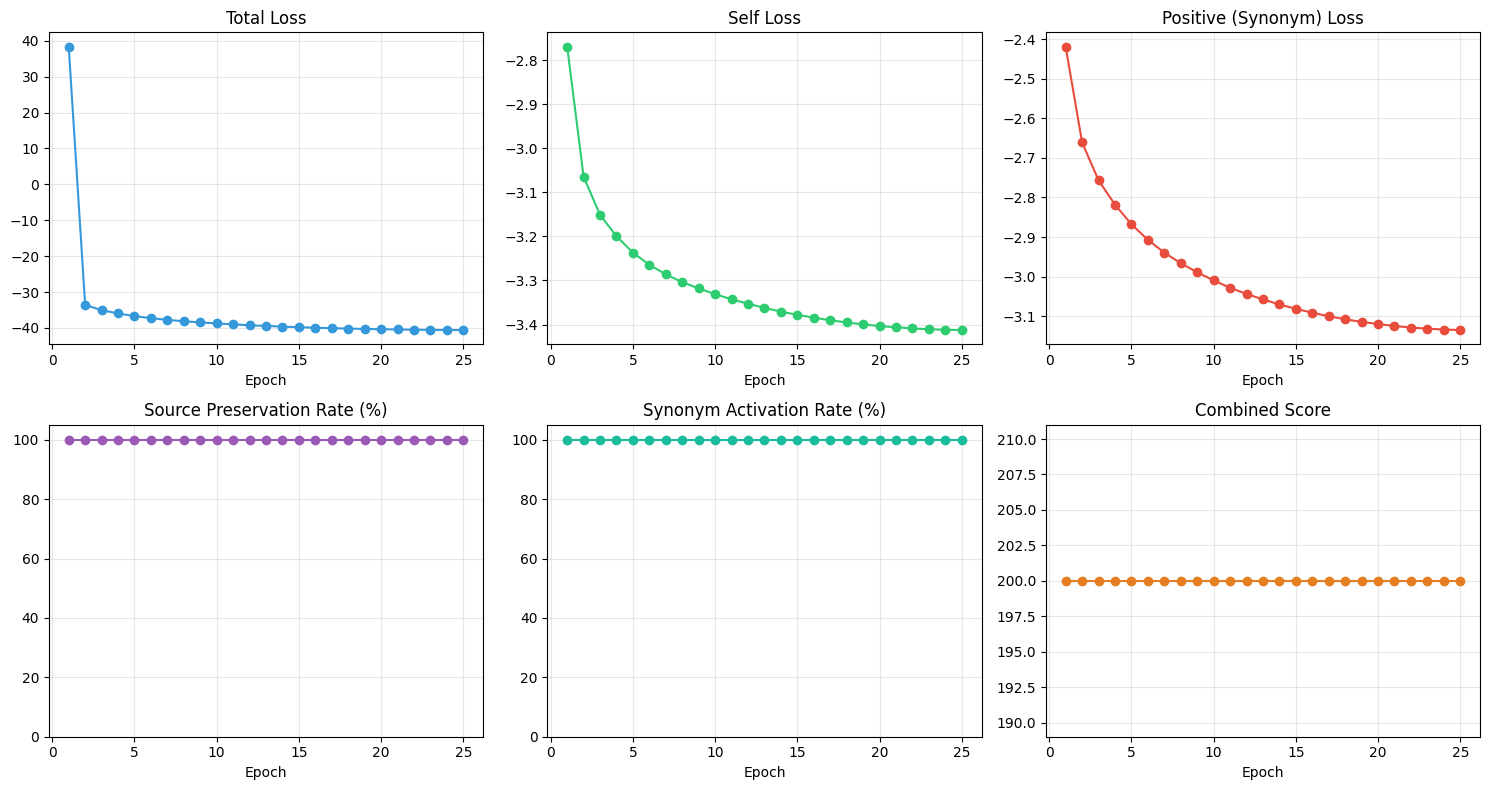

In [12]:
# Plot training curves
if history:
    epochs = range(1, len(history) + 1)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    axes[0, 0].plot(epochs, [h['total'] for h in history], '-o', color='#3498db')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(epochs, [h['self'] for h in history], '-o', color='#2ecc71')
    axes[0, 1].set_title('Self Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].grid(True, alpha=0.3)

    # Use 'positive' key with fallback to 'synonym'
    positive_values = [h.get('positive', h.get('synonym', 0)) for h in history]
    axes[0, 2].plot(epochs, positive_values, '-o', color='#e74c3c')
    axes[0, 2].set_title('Positive (Synonym) Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].grid(True, alpha=0.3)

    axes[1, 0].plot(epochs, [h.get('source_rate', 0) for h in history], '-o', color='#9b59b6')
    axes[1, 0].set_title('Source Preservation Rate (%)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylim(0, 105)
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(epochs, [h.get('synonym_rate', 0) for h in history], '-o', color='#1abc9c')
    axes[1, 1].set_title('Synonym Activation Rate (%)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylim(0, 105)
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].plot(epochs, [h.get('combined_score', 0) for h in history], '-o', color='#e67e22')
    axes[1, 2].set_title('Combined Score')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 9. Tokenization Analysis

In [13]:
# Analyze tokenization for synonym pairs
print("=" * 80)
print("Tokenization Analysis: Source vs Synonym")
print("=" * 80)

synonym_pairs = [
    ("추천", "권장"),
    ("검색", "탐색"),
    ("인공지능", "AI"),
    ("데이터베이스", "DB"),
    ("저장", "담기"),
    ("삭제", "지우기"),
]

print(f"\n{'Source':<15} {'Synonym':<15} {'Source Tokens':<25} {'Synonym Tokens':<25}")
print("-" * 80)

for source, synonym in synonym_pairs:
    src_tokens = tokenizer.tokenize(source)
    syn_tokens = tokenizer.tokenize(synonym)
    src_str = " | ".join(src_tokens[:5])
    syn_str = " | ".join(syn_tokens[:5])
    print(f"{source:<15} {synonym:<15} {src_str:<25} {syn_str:<25}")

Tokenization Analysis: Source vs Synonym

Source          Synonym         Source Tokens             Synonym Tokens           
--------------------------------------------------------------------------------
추천              권장              추천                        권장                       
검색              탐색              검색                        탐색                       
인공지능            AI              인공지능                      AI                       
데이터베이스          DB              데이터베이스                    DB                       
저장              담기              저장                        담 | ##기                  
삭제              지우기             삭제                        지우 | ##기                 


# v21.2 Conclusion

### v21.2 Model Summary

| Feature | Value |
|---------|-------|
| Base Model | skt/A.X-Encoder-base |
| Training Goal | Korean → Korean synonym expansion (Legal/Medical) |
| Domains | 14 domains (General + Legal + Medical) |
| Loss Functions | Self + Synonym + Margin + FLOPS |

### Key Improvements over v21.1

| Aspect | v21.1 | v21.2 |
|--------|-------|-------|
| Domains | 10 general | **14 domains (+법률, +의료)** |
| Legal Terms | None | **판례, 법령, 조문** |
| Medical Terms | None | **의료법, 질환, 증상** |
| Similarity Threshold | 0.7 | **0.75 (stricter)** |
| Learning Rate | 5e-6 | **3e-6 (stable)** |
| Epochs | 20 | **25 (more training)** |

### Use Cases

1. **General Korean search**: Expand user queries with Korean synonyms
2. **Legal document search**: Match 법률 용어, 판례, 계약 관련 문서
3. **Medical record search**: Match 의료 용어, 증상, 진단 관련 문서
4. **Cross-domain search**: Unified model for general + specialized domains